In [1]:
from devito import Grid, Function, TimeFunction, Eq, solve, Operator

In [2]:
# create a unit square finite difference grid with 5 rows, 6 columns
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

In [3]:
# initialise a function to store data over the grid
f = Function(name='f', grid=grid)
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [4]:
# time dependent functions can also be defined
g = TimeFunction(name='g', grid=grid)
g.data

Data([[[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]],

      [[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [5]:
# note that the default time function is 1st order, meaning 
# it stores the g(t, x, y) and g(t+dt, x, y)
g.shape

(2, 5, 6)

In [6]:
# These functions derive from sympy.Function objects, and we can
# form symbolic derivative expressions from them
print(f"df/dx: {f.dx.evaluate}")
print(f"df/dy: {f.dy.evaluate}")
print(f"dg/dt: {g.dt.evaluate}")

# There also exist convenient shortcuts to express the forward and backward stencil points
print(g.forward)
print(g.backward)

df/dx: -f(x, y)/h_x + f(x + h_x, y)/h_x
df/dy: -f(x, y)/h_y + f(x, y + h_y)/h_y
dg/dt: -g(t, x, y)/dt + g(t + dt, x, y)/dt
g(t + dt, x, y)
g(t - dt, x, y)


In [7]:
# we can also take higher derivatives and specify higher order accuracy derivatives
u = TimeFunction(name='u', grid=grid, space_order=2)
# dxc --> central difference, dxr --> forward difference, dxl --> backward difference)
print(u.dxc.evaluate)
# taking a second derivative
print(u.dx2.evaluate)

-0.5*u(t, x - h_x, y)/h_x + 0.5*u(t, x + h_x, y)/h_x
-2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2


In [8]:
# Devito also provides a shorthand expression for the laplacian
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

In [9]:
# Derivatives of any arbitrary composite expression can easily be generated
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [10]:
v.dt2 + u.laplace

Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2))

In [11]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

In [12]:
# which can, depending on the chosen discretisation, lead to fairly complex stencils
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2)/h_x**2 + (-2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2)/h_x**2 + (-2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2)/h_x**2

# Example

We will solve the advection equation using Devito.

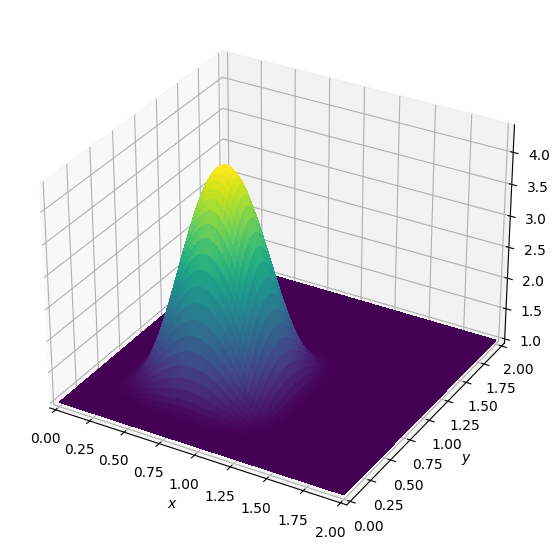

In [13]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

In [14]:
# express the governing equation
eq = Eq(u.dt + c * u.dxl + c * u.dyl)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

In [15]:
# rearrange such that the forward update is on the RHS
stencil = solve(eq, u.forward)
stencil

dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt)

In [16]:
# now combine the full equation for the forward update
update = Eq(u.forward, stencil)
update.evaluate

Eq(u(t + dt, x, y), dt*(-u(t, x, y)/h_y + u(t, x, y - h_y)/h_y - u(t, x, y)/h_x + u(t, x - h_x, y)/h_x + u(t, x, y)/dt))

In [17]:
# everything up until this point is represented symbolically ...
# now generate and compile the optimized C code which can be loaded dynamically do the computations
op = Operator(update)
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, const int nthreads, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  /* Flush denor

Operator `Kernel` ran in 0.01 s


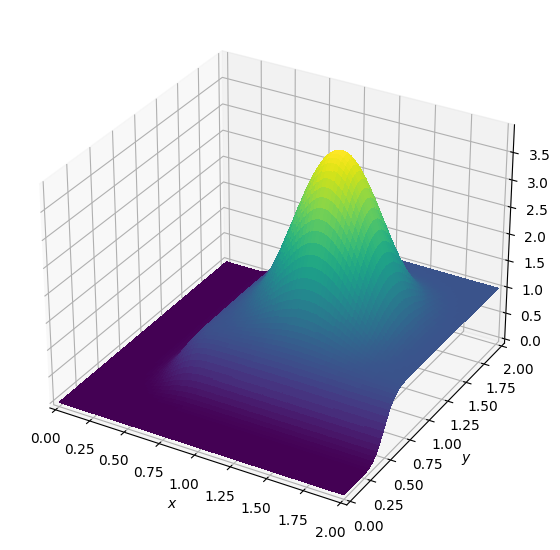

In [18]:
# call the operator to update the function
op(time=nt+1, dt=dt)
plot_field(u.data[1])